In [1]:
import numpy as np
import pandas as pd
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime, timedelta
import math

In [2]:
# UTC_time 변경 함수

def date_convert(date_to_convert):
    pru = datetime.datetime.strptime(date_to_convert, '%a %b %d %H:%M:%S +0000 %Y')+ datetime.timedelta(hours=-240//60)
    return pru.strftime('%b %d %Y %H:%M:%S')

def tzo_convert(tzo_to_convert):
    return  timedelta(hours=tzo_to_convert/60)

In [3]:
nyc_filepath = 'C:/Users/piai/Desktop/code_file/dataset_WWW2019/dataset_TSMC2014_NYC.csv\dataset_TSMC2014_NYC.csv'
custom_date_parser = lambda x: datetime.strptime(x, "%a %b %d %H:%M:%S +0000 %Y")

nyc_data = pd.read_csv(nyc_filepath,parse_dates=['utcTimestamp'],date_parser=custom_date_parser)

nyc_data["utcTimestampOffset"] = nyc_data.utcTimestamp + nyc_data.timezoneOffset.apply(tzo_convert)

nyc_data["hour"] = nyc_data.utcTimestampOffset.dt.hour

# 야행성인지 체크하는 컬럼 생성. 저녁 6시부터 새벽 6시까지 활동한 POI는 야행성 Ture로 표시.
nyc_data["nightlife"] = nyc_data['hour'].apply(lambda x: 'True' if (18 <= x < 24) or (0 <= x < 6)else 'False')

# 요일이 무엇인지 0~6 순서로 설정. 월요일이 0, 일요일이 6.
nyc_data["dayofweek"] = nyc_data.utcTimestampOffset.dt.dayofweek

# 평일과 주말을 구분. 평일이면 True, 주말이면 False.
nyc_data["weekday"] = nyc_data['dayofweek'].apply(lambda x: 'True' if x <= 4 else 'False')

In [4]:
# 유저 아이디 별로 정렬 후
# 유저 아이디 행 수만큼만 len 돌려서 time delta 하고,
# 이대로 컬럼 하나 추가하기.
nyc_data_sorted = nyc_data.sort_values(by=['userId', 'utcTimestampOffset'], ascending=[True, True])
nyc_data_sorted.reset_index(inplace= True, drop= True)

In [5]:
nyc_data_sorted['time_diff'] = (nyc_data_sorted.utcTimestampOffset.shift(-1) - nyc_data_sorted.utcTimestampOffset)

In [6]:
nyc_data_sorted['duplicate'] = False
nyc_data_sorted['timedelta_min'] = nyc_data_sorted['time_diff']/timedelta(minutes=1)

In [7]:
for i in range(1, len(nyc_data_sorted) -1):
    if i == len(nyc_data_sorted) - 1:
        continue
    if nyc_data_sorted.loc[i, "userId"] == nyc_data_sorted.loc[i-1, "userId"]:
        if ((nyc_data_sorted.loc[i, 'venueCategory'] == nyc_data_sorted.loc[i-1, 'venueCategory']) & (nyc_data_sorted.loc[i, 'timedelta_min'] < 60)) | (nyc_data_sorted.loc[i-1, 'timedelta_min'] < 3):
            # 같은 아이디 내에서 카테고리가 연달아 중복되는데, POI 인증 시간차가 60min 미만인 경우 or 다음 POI까지 인증이 3min 미만인 경우(POI는 다르게 중복 인증하는 실수를 한 경우)는 중복이라고 체크.
            nyc_data_sorted.loc[i, 'duplicate'] = True
    if (i > 0) & (nyc_data_sorted.loc[i, "userId"] != nyc_data_sorted.loc[i-1, "userId"]):
        nyc_data_sorted.loc[i-1, 'time_diff'] = pd.to_timedelta(0, unit='h')

In [8]:
# 중복 제거
condition = nyc_data_sorted[nyc_data_sorted['duplicate'] == True].index
nyc_data_sorted.drop(condition, inplace= True)

In [9]:
# POI 인증별 시간차 다시 update
nyc_data_sorted['time_diff'] = (nyc_data_sorted.utcTimestampOffset.shift(-1) - nyc_data_sorted.utcTimestampOffset)
nyc_data_sorted['timedelta_min'] = nyc_data_sorted['time_diff']/timedelta(minutes=1)
nyc_data_sorted.reset_index(inplace= True, drop= True)

In [170]:
poi_list = pd.read_csv('C:/Users/piai/Desktop/code_file/category_list_for_categorize_for_lstm_update.txt', header = None)
poi_list.columns = ['venueCategory','Category']
poi_list.head()

,venueCategory,Category
0,Post Office,Other
1,Jazz Club,Liquid
2,Gym,Exercise
3,Indian Restaurant,Meal
4,Sandwich Place,Meal


In [171]:
tmp_df = nyc_data_sorted[(nyc_data_sorted['timedelta_min'] < 60)]
tmp_df2 = nyc_data_sorted.loc[[(i + 1) for i in list(tmp_df.index)]]
tmp_df3 = pd.concat([tmp_df, tmp_df2])

tmp_df3 = tmp_df3.sort_values(['userId', 'utcTimestampOffset'])
tmp_df3.drop_duplicates(inplace=True)

# tmp_df3를 가지고 세션 데이터를 생성해보자.
tmp_df3['SessionId'] = None

In [363]:
tmp_df3['Category'].value_counts()

Meal              8927
Transportation    8003
Shopping          7427
Other             6297
Work              5466
Residence         3815
Liquid            2980
Leisure           2975
Cafe              2639
Entertain         2538
School            1965
Snack             1864
Sightseeing       1392
Retail            1226
Exercise          1098
Resort             657
Event              401
Hobby              387
Name: Category, dtype: int64

In [173]:
tmp_df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60057 entries, 16 to 192125
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype          
---  ------              --------------  -----          
 0   userId              60057 non-null  int64          
 1   venueId             60057 non-null  object         
 2   venueCategoryId     60057 non-null  object         
 3   venueCategory       60057 non-null  object         
 4   latitude            60057 non-null  float64        
 5   longitude           60057 non-null  float64        
 6   timezoneOffset      60057 non-null  int64          
 7   utcTimestamp        60057 non-null  datetime64[ns] 
 8   utcTimestampOffset  60057 non-null  datetime64[ns] 
 9   hour                60057 non-null  int64          
 10  nightlife           60057 non-null  object         
 11  dayofweek           60057 non-null  int64          
 12  weekday             60057 non-null  object         
 13  time_diff           60057 non

In [174]:
index = 0
SessionId = 0
last = nyc_data_sorted.loc[len(nyc_data_sorted)-1, 'userId']
for i in range(len(tmp_df3)):
    tmp_df3.iloc[i, -1] = SessionId
    if tmp_df3.iloc[i, -2] >= 60:
        SessionId += 1

In [175]:
tmp_df3.head(20)

,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp,utcTimestampOffset,hour,nightlife,dayofweek,weekday,time_diff,duplicate,timedelta_min,SessionId
16,1,4afca7e0f964a520d02422e3,4bf58dd8d48988d1d1941735,Ramen / Noodle House,40.757197,-73.968780,-240,2012-04-14 21:24:08,2012-04-14 17:24:08,17,False,5,False,0 days 00:43:35,False,43.583333,0
17,1,4e742aabc65bb91db3cadb79,4bf58dd8d48988d116941735,Bar,40.757305,-73.968640,-240,2012-04-14 22:07:43,2012-04-14 18:07:43,18,True,5,False,0 days 01:07:24,False,67.400000,0
28,1,3fd66200f964a520f0e51ee3,4bf58dd8d48988d10d951735,Record Shop,40.728912,-73.999300,-240,2012-04-21 18:22:21,2012-04-21 14:22:21,14,False,5,False,0 days 00:26:37,False,26.616667,1
29,1,49dc03d9f964a520445f1fe3,4bf58dd8d48988d116941735,Bar,40.729658,-73.998515,-240,2012-04-21 18:48:58,2012-04-21 14:48:58,14,False,5,False,0 days 00:29:51,False,29.850000,1
30,1,4a58cd1af964a520e8b71fe3,4bf58dd8d48988d122951735,Electronics Store,40.726034,-73.996309,-240,2012-04-21 19:18:49,2012-04-21 15:18:49,15,False,5,False,0 days 00:41:54,False,41.900000,1
31,1,4ab53dabf964a520857320e3,4bf58dd8d48988d1fe941735,Music Store,40.726483,-73.984286,-240,2012-04-21 20:00:43,2012-04-21 16:00:43,16,False,5,False,0 days 00:17:36,False,17.600000,1
32,1,4c78103edf08a1cd411fd65d,4bf58dd8d48988d14c941735,Wings Joint,40.725454,-73.987955,-240,2012-04-21 20:18:19,2012-04-21 16:18:19,16,False,5,False,0 days 06:03:06,False,363.100000,1
38,1,4af33b2af964a520edeb21e3,4bf58dd8d48988d128951735,Gift Shop,40.775911,-73.980051,-240,2012-05-01 22:08:18,2012-05-01 18:08:18,18,True,1,True,0 days 00:07:05,False,7.083333,2
39,1,42586c80f964a520db201fe3,4bf58dd8d48988d121941735,Bar,40.775986,-73.979528,-240,2012-05-01 22:15:23,2012-05-01 18:15:23,18,True,1,True,3 days 16:44:32,False,5324.533333,2
60,1,4de3e4effa7651589f21983d,4bf58dd8d48988d11e941735,Bar,40.721488,-73.995029,-240,2012-05-29 23:15:10,2012-05-29 19:15:10,19,True,1,True,0 days 00:35:05,False,35.083333,3


In [14]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [176]:
tmp_df3 = pd.merge(tmp_df3,poi_list, how='left', left_on='venueCategory', right_on='venueCategory')

In [177]:
tmp_df3.loc[tmp_df3['venueCategory'].str.contains('Caf'), 'Category'] = 'Cafe'
tmp_df3.loc[tmp_df3['venueCategory'].str.contains('Gas Station'), 'Category'] = 'Other'
tmp_df3[tmp_df3['Category'].isnull()]

,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp,utcTimestampOffset,hour,nightlife,dayofweek,weekday,time_diff,duplicate,timedelta_min,SessionId,Category


In [178]:
tmp_df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60057 entries, 0 to 60056
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype          
---  ------              --------------  -----          
 0   userId              60057 non-null  int64          
 1   venueId             60057 non-null  object         
 2   venueCategoryId     60057 non-null  object         
 3   venueCategory       60057 non-null  object         
 4   latitude            60057 non-null  float64        
 5   longitude           60057 non-null  float64        
 6   timezoneOffset      60057 non-null  int64          
 7   utcTimestamp        60057 non-null  datetime64[ns] 
 8   utcTimestampOffset  60057 non-null  datetime64[ns] 
 9   hour                60057 non-null  int64          
 10  nightlife           60057 non-null  object         
 11  dayofweek           60057 non-null  int64          
 12  weekday             60057 non-null  object         
 13  time_diff           60057 non-n

In [179]:
id2idx = {item_id : index for index, item_id in enumerate(tmp_df3['Category'].unique())}

In [180]:
def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))
    # id2idx에 없는 아이템은 모르는 값(-1) 처리.
    return df

In [181]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있다.
# 이를 위해 반복문을 통해 지속적으로 제거한다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('Category').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['Category'].isin(item_use)]
    return data

In [182]:
data = cleanse_recursive(tmp_df3, shortest=3, least_click=5)
data

,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp,utcTimestampOffset,hour,nightlife,dayofweek,weekday,time_diff,duplicate,timedelta_min,SessionId,Category
2,1,3fd66200f964a520f0e51ee3,4bf58dd8d48988d10d951735,Record Shop,40.728912,-73.999300,-240,2012-04-21 18:22:21,2012-04-21 14:22:21,14,False,5,False,0 days 00:26:37,False,26.616667,1,Hobby
3,1,49dc03d9f964a520445f1fe3,4bf58dd8d48988d116941735,Bar,40.729658,-73.998515,-240,2012-04-21 18:48:58,2012-04-21 14:48:58,14,False,5,False,0 days 00:29:51,False,29.850000,1,Liquid
4,1,4a58cd1af964a520e8b71fe3,4bf58dd8d48988d122951735,Electronics Store,40.726034,-73.996309,-240,2012-04-21 19:18:49,2012-04-21 15:18:49,15,False,5,False,0 days 00:41:54,False,41.900000,1,Shopping
5,1,4ab53dabf964a520857320e3,4bf58dd8d48988d1fe941735,Music Store,40.726483,-73.984286,-240,2012-04-21 20:00:43,2012-04-21 16:00:43,16,False,5,False,0 days 00:17:36,False,17.600000,1,Shopping
6,1,4c78103edf08a1cd411fd65d,4bf58dd8d48988d14c941735,Wings Joint,40.725454,-73.987955,-240,2012-04-21 20:18:19,2012-04-21 16:18:19,16,False,5,False,0 days 06:03:06,False,363.100000,1,Meal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60022,1083,3fd66200f964a520dbe61ee3,4bf58dd8d48988d11a941735,Other Nightlife,40.718836,-73.995390,-240,2012-04-14 04:47:06,2012-04-14 00:47:06,0,True,5,False,0 days 00:21:02,False,21.033333,24661,Entertain
60023,1083,4137b400f964a520d01a1fe3,4bf58dd8d48988d116941735,Bar,40.729101,-74.000980,-240,2012-04-14 05:08:08,2012-04-14 01:08:08,1,True,5,False,0 days 10:31:13,False,631.216667,24661,Liquid
60046,1083,42911d00f964a520f5231fe3,4bf58dd8d48988d129951735,Train Station,40.750795,-73.993576,-240,2012-10-08 12:39:42,2012-10-08 08:39:42,8,False,0,True,0 days 00:11:17,False,11.283333,24673,Transportation
60047,1083,4b191885f964a520efd723e3,4bf58dd8d48988d148941735,Donut Shop,40.746209,-73.994099,-240,2012-10-08 12:50:59,2012-10-08 08:50:59,8,False,0,True,0 days 00:05:33,False,5.550000,24673,Snack


In [183]:
data = data[['SessionId', 'utcTimestampOffset', 'Category']]

In [184]:
data

,SessionId,utcTimestampOffset,Category
2,1,2012-04-21 14:22:21,Hobby
3,1,2012-04-21 14:48:58,Liquid
4,1,2012-04-21 15:18:49,Shopping
5,1,2012-04-21 16:00:43,Shopping
6,1,2012-04-21 16:18:19,Meal
...,...,...,...
60022,24661,2012-04-14 00:47:06,Entertain
60023,24661,2012-04-14 01:08:08,Liquid
60046,24673,2012-10-08 08:39:42,Transportation
60047,24673,2012-10-08 08:50:59,Snack


In [185]:
data.columns = ['SessionId', 'Time', 'ItemId']

In [186]:
data.sort_values(by=['SessionId', 'Time'], inplace=True) # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html
data.shape

(23919, 3)

In [187]:
data

,SessionId,Time,ItemId
2,1,2012-04-21 14:22:21,Hobby
3,1,2012-04-21 14:48:58,Liquid
4,1,2012-04-21 15:18:49,Shopping
5,1,2012-04-21 16:00:43,Shopping
6,1,2012-04-21 16:18:19,Meal
...,...,...,...
60022,24661,2012-04-14 00:47:06,Entertain
60023,24661,2012-04-14 01:08:08,Liquid
60046,24673,2012-10-08 08:39:42,Transportation
60047,24673,2012-10-08 08:50:59,Snack


In [188]:
total_dataset = indexing(data, id2idx)
total_dataset = SessionDataset(data)
total_dataset.df.tail(20)

,SessionId,Time,ItemId,item_idx
59999,24653,2012-05-15 19:23:31,Work,6
60000,24653,2012-05-15 19:29:22,Transportation,11
60001,24653,2012-05-15 19:49:56,Other,10
60002,24653,2012-05-15 20:12:15,Liquid,1
60003,24654,2012-05-17 07:35:42,Transportation,11
60004,24654,2012-05-17 07:54:39,Shopping,3
60005,24654,2012-05-17 08:04:05,Transportation,11
60006,24655,2012-05-21 06:53:00,Residence,8
60007,24655,2012-05-21 07:33:05,Transportation,11
60008,24655,2012-05-21 07:56:23,Shopping,3


In [189]:
len_more_than_3 = len(total_dataset.df['SessionId'].drop_duplicates())

In [190]:
tmp_total = total_dataset.df

In [191]:
tmp_total

,SessionId,Time,ItemId,item_idx
2,1,2012-04-21 14:22:21,Hobby,2
3,1,2012-04-21 14:48:58,Liquid,1
4,1,2012-04-21 15:18:49,Shopping,3
5,1,2012-04-21 16:00:43,Shopping,3
6,1,2012-04-21 16:18:19,Meal,0
...,...,...,...,...
60022,24661,2012-04-14 00:47:06,Entertain,4
60023,24661,2012-04-14 01:08:08,Liquid,1
60046,24673,2012-10-08 08:39:42,Transportation,11
60047,24673,2012-10-08 08:50:59,Snack,7


In [192]:
arr = np.empty((0,3), int)

for i in range(len_more_than_3):
    tmp = tmp_total[tmp_total['SessionId'] == i]
    if len(tmp) >= 3:
        # print('input')
        input = tmp.iloc[:2]['item_idx']
        # print(tmp.iloc[:2]['item_idx'])
        # print('output')
        output = tmp[2:3]['item_idx']
        # print(tmp[2:3]['item_idx'])
        in_and_out = tmp[:3]['item_idx']
        array = np.array(in_and_out)
        arr = np.append(arr, [np.array(in_and_out)], axis=0)

In [193]:
id2idx

{'Meal': 0,
 'Liquid': 1,
 'Hobby': 2,
 'Shopping': 3,
 'Entertain': 4,
 'Retail': 5,
 'Work': 6,
 'Snack': 7,
 'Residence': 8,
 'Cafe': 9,
 'Other': 10,
 'Transportation': 11,
 'Leisure': 12,
 'Sightseeing': 13,
 'Resort': 14,
 'Exercise': 15,
 'School': 16,
 'Event': 17}

In [194]:
pd.Series(arr[:,-1][int(len(arr)*0.7):]).drop_duplicates().sort_values()

0       0
8       1
336     2
19      3
1       4
94      5
2       6
40      7
14      8
18      9
4      10
49     11
10     12
41     13
70     14
5      15
39     16
133    17
dtype: int64

In [195]:
print(arr[:,:-1])
print(arr[:,-1])
# input과 output으로 잘 쪼개졌다.

[[ 2  1]
 [ 5  1]
 [11  3]
 ...
 [ 0 11]
 [10 11]
 [ 8 12]]
[ 3  3  6 ... 11  0  0]


In [196]:
print('X shape : ', arr[:,:-1].shape)
print('Y shape : ', arr[:,-1].shape)

X shape :  (1773, 2)
Y shape :  (1773,)


In [233]:
# split
data_train = arr[:int(len(arr)*0.7)]
data_val = arr[int(len(arr)*0.7):int(len(arr)*0.9)]
data_test = arr[int(len(arr)*0.9):]

In [234]:
x_train = data_train[:,:-1]
y_train = data_train[:,-1]

x_val = data_val[:,:-1]
y_val = data_val[:,-1]

x_test = data_test[:,:-1]
y_test = data_test[:,-1]

In [235]:
import matplotlib.pyplot as pltfrom
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, GRU
from keras.preprocessing import sequence
from keras.utils import np_utils

import numpy
import tensorflow as tf
import matplotlib.pyplot as plt

y_train = np_utils.to_categorical(y_train)
y_val = np_utils.to_categorical(y_val)
y_test = np_utils.to_categorical(y_test)

In [268]:
regression_GRU = Sequential()

regression_GRU.add(Embedding(1000,100))
regression_GRU.add(GRU(units=100, activation="relu", return_sequences=True, input_shape = (x_train.shape[1], 5)))
regression_GRU.add(Dropout(0.2))

regression_GRU.add(GRU(units=60, activation="relu", return_sequences=True))
regression_GRU.add(Dropout(0.3))

regression_GRU.add(GRU(units=80, activation="relu", return_sequences=True))
regression_GRU.add(Dropout(0.4))

regression_GRU.add(GRU(units=120, activation="relu"))
regression_GRU.add(Dropout(0.5))

regression_GRU.add(Dense(units = 18,activation='softmax'))

In [258]:
model = Sequential()
model.add(Embedding(1000,100))
model.add(GRU(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(18, activation='softmax'))

In [259]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [260]:
y_train.shape

(1241, 18)

In [261]:
history = model.fit(x_train, y_train, batch_size=100, epochs=20, validation_data=(x_val, y_val))

Epoch 1/20
13/13 [==============================] - 3s 34ms/step - loss: 2.8778 - accuracy: 0.1249 - val_loss: 2.8606 - val_accuracy: 0.1215
Epoch 2/20
13/13 [==============================] - 0s 8ms/step - loss: 2.8419 - accuracy: 0.1684 - val_loss: 2.8142 - val_accuracy: 0.1441
Epoch 3/20
13/13 [==============================] - 0s 8ms/step - loss: 2.7803 - accuracy: 0.1741 - val_loss: 2.7305 - val_accuracy: 0.1497
Epoch 4/20
13/13 [==============================] - 0s 8ms/step - loss: 2.6859 - accuracy: 0.1700 - val_loss: 2.6140 - val_accuracy: 0.1554
Epoch 5/20
13/13 [==============================] - 0s 8ms/step - loss: 2.6073 - accuracy: 0.1595 - val_loss: 2.5594 - val_accuracy: 0.1582
Epoch 6/20
13/13 [==============================] - 0s 9ms/step - loss: 2.5791 - accuracy: 0.1813 - val_loss: 2.5375 - val_accuracy: 0.1893
Epoch 7/20
13/13 [==============================] - 0s 9ms/step - loss: 2.5558 - accuracy: 0.2055 - val_loss: 2.5252 - val_accuracy: 0.1921
Epoch 8/20
13/13 [=

In [281]:
regression_GRU.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [282]:
#history = regression_GRU.fit(x_train, y_train, batch_size=100, epochs=20, validation_data=(x_val, y_val))
GRU_history = regression_GRU.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))

Epoch 1/10
39/39 [==============================] - 7s 30ms/step - loss: 2.5683 - accuracy: 0.1821 - val_loss: 2.5760 - val_accuracy: 0.1610
Epoch 2/10
39/39 [==============================] - 0s 11ms/step - loss: 2.5548 - accuracy: 0.1805 - val_loss: 2.5654 - val_accuracy: 0.1610
Epoch 3/10
39/39 [==============================] - 0s 11ms/step - loss: 2.5541 - accuracy: 0.1869 - val_loss: 2.5655 - val_accuracy: 0.1638
Epoch 4/10
39/39 [==============================] - 0s 11ms/step - loss: 2.5477 - accuracy: 0.1805 - val_loss: 2.5439 - val_accuracy: 0.1949
Epoch 5/10
39/39 [==============================] - 0s 11ms/step - loss: 2.5390 - accuracy: 0.1998 - val_loss: 2.5535 - val_accuracy: 0.1977
Epoch 6/10
39/39 [==============================] - 0s 11ms/step - loss: 2.5309 - accuracy: 0.1886 - val_loss: 2.5547 - val_accuracy: 0.2175
Epoch 7/10
39/39 [==============================] - 0s 11ms/step - loss: 2.5344 - accuracy: 0.1894 - val_loss: 2.5505 - val_accuracy: 0.2034
Epoch 8/10
39

In [287]:
print("\n 정확도 : %.4f" % (regression_GRU.evaluate(x_test, y_test)[1]))

6/6 [==============================] - 0s 3ms/step - loss: 2.7210 - accuracy: 0.1124

 정확도 : 0.1124


6/6 [==============================] - 0s 2ms/step - loss: 2.8209 - accuracy: 0.1236

 정확도 : 0.1236


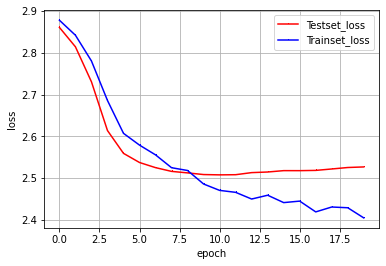

In [262]:
print("\n 정확도 : %.4f" % (model.evaluate(x_test, y_test)[1]))

y_test_loss = history.history['val_loss']
y_train_loss = history.history['loss']

x_len = numpy.arange(len(y_test_loss))
plt.plot (x_len, y_test_loss, marker=',', c='red', label='Testset_loss')
plt.plot(x_len, y_train_loss, marker=',', c='blue', label='Trainset_loss')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [324]:
def top_3_categorical_accuracy(y_true, y_pred):
    return tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=5)

In [325]:
inTop3 = lambda x, y: tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=5)

In [330]:
import keras

In [333]:
regression_GRU.compile('adam', 'categorical_crossentropy', ['accuracy', 'top_k_categorical_accuracy'])

In [359]:
GRU_history = regression_GRU.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))

Epoch 1/10
39/39 [==============================] - 1s 13ms/step - loss: 2.4181 - accuracy: 0.2280 - top_k_categorical_accuracy: 0.6454 - val_loss: 2.6050 - val_accuracy: 0.2147 - val_top_k_categorical_accuracy: 0.6271
Epoch 2/10
39/39 [==============================] - 0s 11ms/step - loss: 2.4172 - accuracy: 0.2474 - top_k_categorical_accuracy: 0.6430 - val_loss: 2.6227 - val_accuracy: 0.2232 - val_top_k_categorical_accuracy: 0.6299
Epoch 3/10
39/39 [==============================] - 0s 11ms/step - loss: 2.4335 - accuracy: 0.2377 - top_k_categorical_accuracy: 0.6454 - val_loss: 2.5961 - val_accuracy: 0.2147 - val_top_k_categorical_accuracy: 0.6158
Epoch 4/10
39/39 [==============================] - 0s 11ms/step - loss: 2.4122 - accuracy: 0.2337 - top_k_categorical_accuracy: 0.6446 - val_loss: 2.5964 - val_accuracy: 0.2062 - val_top_k_categorical_accuracy: 0.6299
Epoch 5/10
39/39 [==============================] - 0s 11ms/step - loss: 2.4126 - accuracy: 0.2417 - top_k_categorical_accur

In [317]:
print("\n 정확도 : %.4f" % (regression_GRU.evaluate(x_test, y_test)[1]))

6/6 [==============================] - 0s 4ms/step - loss: 2.7658 - accuracy: 0.1236 - top_k_categorical_accuracy: 0.4831

 정확도 : 0.1236


In [360]:
y_pred = regression_GRU.predict(x_test)

6/6 [==============================] - 0s 3ms/step


In [361]:
# Top-5 accuracy일 경우,

(sum(tf.keras.metrics.top_k_categorical_accuracy(y_test, y_pred, k=5))
/len(tf.keras.metrics.top_k_categorical_accuracy(y_test, y_pred, k=5)))

<tf.Tensor: shape=(), dtype=float32, numpy=0.47191012>

In [362]:
# Top-3 accuracy일 경우,

(sum(tf.keras.metrics.top_k_categorical_accuracy(y_test, y_pred, k=3))
/len(tf.keras.metrics.top_k_categorical_accuracy(y_test, y_pred, k=3)))

<tf.Tensor: shape=(), dtype=float32, numpy=0.32022473>